In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=[]

env: CUDA_VISIBLE_DEVICES=[]


### Leopard seal vocalizations
Source:
- https://www.mobysound.org/
- http://localhost:8186/tree/Datasets/mobysound/leopard_seal


**Note**: This dataset is very noisy

In [2]:
from pathlib2 import Path
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
from tqdm.autonotebook import tqdm
from librosa.core.time_frequency import mel_frequencies
from avgn_paper.signalprocessing.spectrogramming_tf import spectrogram_tensorflow
from avgn_paper.utils.audio import load_wav, float32_to_int16, int16_to_float32, write_wav
from avgn_paper.visualization.spectrogram import visualize_spec, plot_spec
from avgn_paper.utils.general import HParams
from avgn_paper.signalprocessing.filtering import butter_bandpass_filter

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### data locations

In [4]:
DSLOC = Path('/mnt/cube/Datasets/mobysound/crabeater_seal/')
readme = DSLOC/'readme_1st.txt'
readme = [line for line in open(readme, 'r')]  

In [5]:
DSLOC

PosixPath('/mnt/cube/Datasets/mobysound/crabeater_seal')

### Load labels

In [10]:
LABEL_LOC = DSLOC / 'low_moan.xls'

In [11]:
rate = 1000

In [12]:
def get_sec(time_str):
    if '.' in time_str:
        time_str, ms = time_str.split('.')
    else:
        ms = '0'
    h, m, s = time_str.split(':')
    return int(h) * 3600 + int(m) * 60 + int(s) + float('.'+ms)

In [13]:
label_df = pd.read_excel(LABEL_LOC)
label_df['start_time_s'] = [get_sec(time_str) for time_str in label_df['Start time [hh:mm:ss.ss]'].values]
label_df['end_time_s'] = [get_sec(time_str) for time_str in label_df['End time [hh:mm:ss.ss]'].values]
len(label_df)

3940

In [14]:
label_df[:3]

,Start time [hh:mm:ss.ss],End time [hh:mm:ss.ss],Start time [s],End time [s],Duration [s],Low frequency [Hz],High frequency [Hz],Bandwidth [Hz],start_time_s,end_time_s
0,0:00:00.27,0:00:03.28,0.2746,3.2769,3.0023,169.1974,1340.5640,1171.3666,0.27,3.28
1,0:00:19.46,0:00:23.01,19.4600,23.0114,3.5515,151.8438,1167.0282,1015.1844,19.46,23.01
2,0:00:31.40,0:00:34.51,31.3959,34.5080,3.1121,65.0759,1201.7354,1136.6594,31.40,34.51


### Make wav dataset

In [15]:
wavs = list((DSLOC / 'data').glob('2*.wav'))
wavs.sort()
len(wavs)
wavs[:3]

[PosixPath('/mnt/cube/Datasets/mobysound/crabeater_seal/data/20071101-0000.wav'),
 PosixPath('/mnt/cube/Datasets/mobysound/crabeater_seal/data/20071101-0001.wav'),
 PosixPath('/mnt/cube/Datasets/mobysound/crabeater_seal/data/20071101-0002.wav')]

In [16]:
long_wav = np.concatenate([load_wav(wav_loc)[1] for wav_loc in tqdm(wavs)])

In [17]:
len(long_wav)

1023354816

In [18]:
wav_ds = pd.DataFrame(columns = ['rate', 'data', 'file', 'wloc', 'wav_st', 'wav_et', 'ds_len'])
st = 0
for wav_loc in tqdm(wavs):
    rate, data = load_wav(wav_loc)
    ds_len = len(data)/rate
    wav_ds.loc[len(wav_ds)] = [rate, data, wav_loc.stem, wav_loc, st, st+ds_len, ds_len]
    st+=ds_len

In [19]:
np.unique(wav_ds.rate.values)

array([24000], dtype=object)

In [20]:
wav_ds[:5]

,rate,data,file,wloc,wav_st,wav_et,ds_len
0,24000,"[6, 44, 39, 39, 17, 17, 27, 16, 62, 64, 67, 49...",20071101-0000,/mnt/cube/Datasets/mobysound/crabeater_seal/da...,0,60.012,60.012
1,24000,"[21, 25, 37, 13, 20, -10, -1, 24, -5, 1, 6, -1...",20071101-0001,/mnt/cube/Datasets/mobysound/crabeater_seal/da...,60.012,120.024,60.012
2,24000,"[-12, -73, 23, -94, -15, -43, -43, -96, -42, 3...",20071101-0002,/mnt/cube/Datasets/mobysound/crabeater_seal/da...,120.024,180.036,60.012
3,24000,"[133, 116, 179, 121, 158, 127, 110, 112, 110, ...",20071101-0003,/mnt/cube/Datasets/mobysound/crabeater_seal/da...,180.036,238.568,58.532
4,24000,"[-444, -483, -400, -323, -168, -131, -43, 57, ...",20071101-0004,/mnt/cube/Datasets/mobysound/crabeater_seal/da...,238.568,298.580,60.012


### grab a single test syllable

In [80]:
win_length_ms = 2000
hop_length_ms = 10
print(win_length_ms / 1000 * rate)

hparams = HParams(
    # spectrogramming
    win_length=int(rate / 1000 * win_length_ms),
    n_fft=4096 * 2,
    hop_length=int(rate / 1000 * hop_length_ms),
    ref_level_db=20,
    min_level_db=-70,
    # mel scaling
    num_mel_bins=128,
    mel_lower_edge_hertz=100,
    mel_upper_edge_hertz=500,
    # inversion
    power=1.5,  # for spectral inversion
    griffin_lim_iters=50,
    pad=True,
    #
)

# create a filter to convolve with the spectrogram
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=hparams.num_mel_bins,
    num_spectrogram_bins=int(hparams.n_fft / 2) + 1,
    sample_rate=rate,
    lower_edge_hertz=hparams.mel_lower_edge_hertz,
    upper_edge_hertz=hparams.mel_upper_edge_hertz,
    dtype=tf.dtypes.float32,
    name=None,
)
# gets the center frequencies of mel bands
mel_f = mel_frequencies(
    n_mels=hparams.num_mel_bins + 2,
    fmin=hparams.mel_lower_edge_hertz,
    fmax=hparams.mel_upper_edge_hertz,
)
# Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
enorm = tf.dtypes.cast(
    tf.expand_dims(
        tf.constant(
            2.0 / (mel_f[2 : hparams.num_mel_bins + 2] - mel_f[: hparams.num_mel_bins])
        ),
        0,
    ),
    tf.float32,
)
mel_matrix = tf.multiply(mel_matrix, enorm)
mel_matrix = tf.divide(mel_matrix, tf.reduce_sum(mel_matrix, axis=0))

48000.0


In [84]:
len(label_df)

3940

In [86]:
nex = 2000
syll_row = label_df.iloc[nex]
syll_data = long_wav[int(syll_row.start_time_s*rate):int(syll_row.end_time_s*rate)]
#syll_data = butter_bandpass_filter(syll_data, lowcut = syll_row['Low frequency [Hz]'], highcut=syll_row['High frequency [Hz]'], fs=rate, order=2)
spectrogram = spectrogram_tensorflow(int16_to_float32(syll_data), hparams)
mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1)

(-0.5, 374.5, -0.5, 127.5)

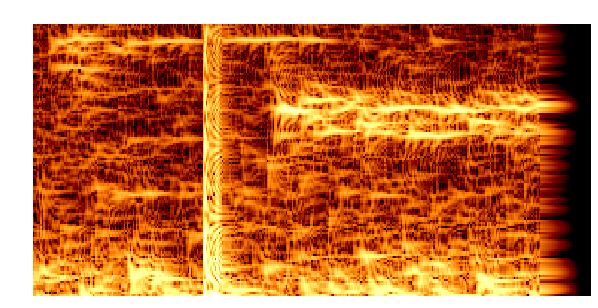

In [87]:
fig, ax = plt.subplots(figsize=(10,5))
ax.matshow(mel_spectrogram.numpy().T, origin='lower', aspect='auto', cmap = plt.cm.afmhot)
ax.axis('off')